# Petri dish detection and extraction 

### DataLab task 2

#### Client requirements 
- Your code should rely on traditional computer vision methods. In other words, do not use an ML/DL model.
- Detected Petri dish edges must be within ± 30 pixels of the actual Petri dish edges.
- The code should be general enough to work on all the dataset images (Y2B_23 and Y2B_24).
- The output of the code must be a square.
- An image similar to Figure 2.1 is shown in task_2.ipynb.

#### Deliverables
- The code (task_2.ipynb), with comments/docstrings explaining each step. 
- The notebook should display the output of the code on two random images from Y2B_23 and two random images from Y2B_24 (Figure 2.1).

## Imports

As always I begin with an import cell, I import all of my packages in here in order to keep track of all the imports. 

In [3]:
import cv2

import numpy as np
import matplotlib.pyplot as plt

#### Path to images 

The requirements state that I the code should work on at least 4 images: 2 from 2023 and 2 from 2024. I load the images here so it's easier to come back to rather than after the definition of my code, this removes the need to look through my whole code if a change in path is needed. I also display all the images to ensure that it is the correct path and the images visualize properly.

In [4]:
# 2024 images 
im1 = cv2.imread('/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/Task_2/train_Shival_231265_im1 copy.png')
im2 = cv2.imread('/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/Task_2/train_Shival_231265_im3 copy.png')

# 2023 images 
im3 = cv2.imread('/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/Task_2/DataLab_2_2023.png')
im4 = cv2.imread('/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/Task_2/DataLab_2_20231.png')

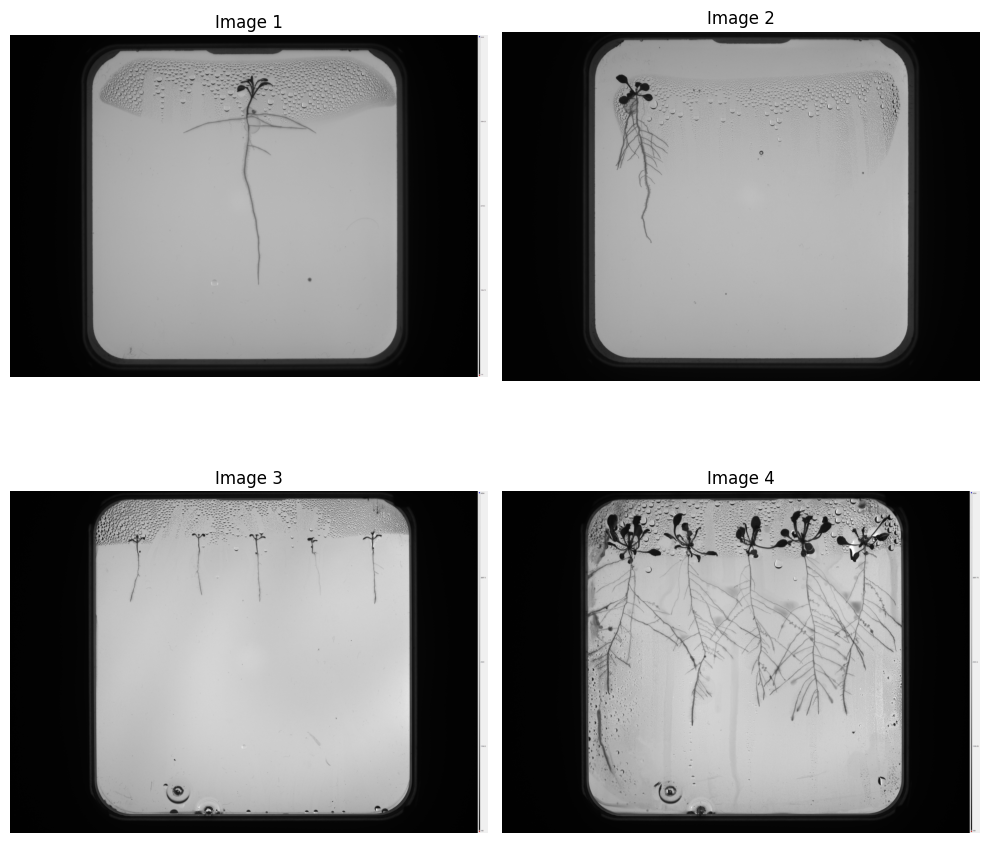

In [5]:
plt.figure(figsize=(10, 10))  

# Display the first image
plt.subplot(2, 2, 1)
plt.imshow(im1)
plt.title("Image 1")  
plt.axis('off')    

# Display the second image
plt.subplot(2, 2, 2)
plt.imshow(im2)
plt.title("Image 2")
plt.axis('off')

# Display the third image
plt.subplot(2, 2, 3)
plt.imshow(im3)
plt.title("Image 3")
plt.axis('off')

# Display the fourth image
plt.subplot(2, 2, 4)
plt.imshow(im4)
plt.title("Image 4")
plt.axis('off')

plt.tight_layout()  
plt.show()


# Code Documentation 

#### prepocessing the image:
 - I started by converting the image to graysclae to reduce the complexity of the image because color information is not needed for edge detection. 
 - Gaussian blur: this smooths out the image to avoid detecting false edges because it reduces the noise. This helps ensure that only relevant features are detcted. I used 5 by 5 because i experimented with different numbers and 5 by 5 produced the best results.
 - Thresholding: Some of my fellow classmates used adaptive thresholding so I looked into different ones and saw that adaptive thresholding works best for images with varying lighting conditions, which is perfect for the petri dishes. The values 11 and 2 were chosen after multiple iterations, because they worked the best. 
 - Equalizing: The edges weren't detecting properly and after some research (and chatgpt) I saw that equalizing might help, and it did so I included it. 

 #### Detecting edges:
 - Canny: I used canny edge detection because that is what was used in the self-study notebooks. The lower and upper threshold was decided after a number of iterations, these two worked best for me. 
 - I used morphological closing to close the small gaps in the detected edges. 

 #### Bounding box:
 - Contour: I used findcontours to detect the boundaries and ensured that only the outermost contour gets detected with RETR_EXTERNAL. 
 - I calculated the rectangles for each contour to find the biggest one, which is probably the petri dish. 
 - Area size: I set the minimum size ratio to 0.3 so all the small contours are ignored, and it only considers the contours that are larger than 0.3. This value was decided off of trial and error. 

 #### Bounding box tolerance:
 - I needed for the bounding box to be within a certain range to meet the client requirement so I asked chatgpt to help me define a fucntion for that. I adjusted it based on what did and didn't work for my images. 

 #### Crop to square:
 - I centered the petri dish and cropped around the bounding box to a square so it focuses on the petri dish and ignores the surrounding areas. Again to ensure that I meet the client requiremnt of 30 pixels around the petri dish I added to tolerance parameters. 

 #### Process and display:
 - I processed the image, converted it to grayscale, applied the thresholding and equalized it. 
 - Edges: I detected the edges use the bounding box function to find the largest bounding boc. 
 - Then I checked whether the detected bounding box is within the tolerance range. 
 - If the image meets all the requirements, I cropped the images to square them and display the results and the original image. I also converted it back to RGB for displying. 

 




In [ ]:
def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY_INV, 11, 2)
    gray = cv2.equalizeHist(gray)
    return gray, image

def detect_edges(gray):
    edges = cv2.Canny(gray, 50, 150) 
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))  
    return edges

def find_largest_bounding_box(edges, image_shape, min_size_ratio=0.3):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    best_bbox = None
    min_width, min_height = min_size_ratio * image_shape[1], min_size_ratio * image_shape[0]

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area > max_area and w >= min_width and h >= min_height:
            max_area = area
            best_bbox = (x, y, w, h)
    
    return best_bbox

def check_bbox_tolerance(bbox, expected_bbox, tolerance=0):
    if expected_bbox is None:
        return True  
    
    x, y, w, h = bbox
    ex, ey, ew, eh = expected_bbox
    
    # Check if the detected bounding box is within the tolerance of the expected bbox edges
    if (abs(x - ex) <= tolerance and abs(y - ey) <= tolerance and 
        abs(w - ew) <= tolerance and abs(h - eh) <= tolerance):
        return True
    return False

def crop_to_square(image, bbox, padding=5, tolerance=0):
    x, y, w, h = bbox
    size = max(w, h)  
    
    # Center crop around the bounding box
    cx, cy = x + w // 2, y + h // 2
    x1 = max(0, cx - size // 2)
    y1 = max(0, cy - size // 2)
    x2 = min(image.shape[1], x1 + size)
    y2 = min(image.shape[0], y1 + size)

    # Enforce ± tolerance for cropping
    if x1 - tolerance > 0:
        x1 -= tolerance
    if y1 - tolerance > 0:
        y1 -= tolerance
    if x2 + tolerance < image.shape[1]:
        x2 += tolerance
    if y2 + tolerance < image.shape[0]:
        y2 += tolerance

    # Crop the image
    return image[y1:y2, x1:x2]

def process_and_display(image, title, expected_bbox=None):
    gray, original = preprocess_image(image)
    edges = detect_edges(gray)
    bbox = find_largest_bounding_box(edges, gray.shape, min_size_ratio=0.2)  
    
    # Debug visualization
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Edges Detected")
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    
    # Check if the detected bounding box is within tolerance of the expected bbox
    if bbox and check_bbox_tolerance(bbox, expected_bbox):
        cropped = crop_to_square(original, bbox, padding=80, tolerance=0)  
        plt.subplot(1, 2, 2)
        plt.title(f"Cropped Petri Dish: {title}")
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()
    else:
        print(f"Bounding box for {title} is not within the tolerance range.")
        plt.subplot(1, 2, 2)
        plt.title(f"Original Image: {title}")
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()


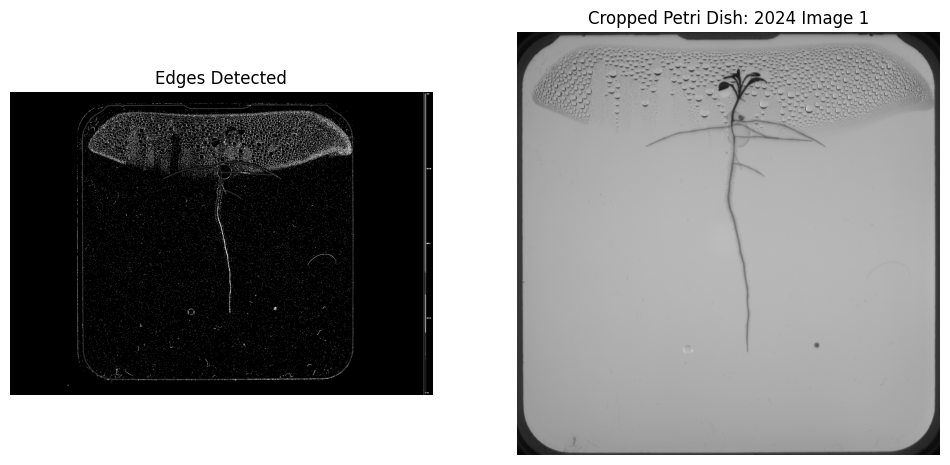

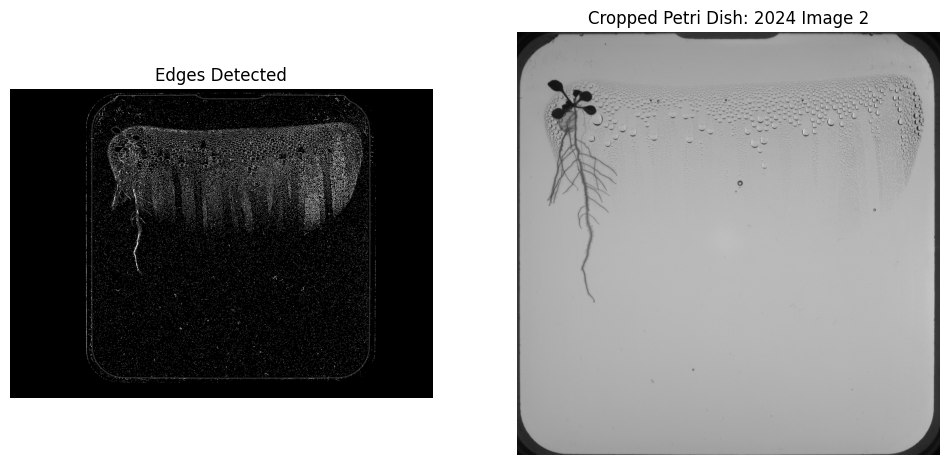

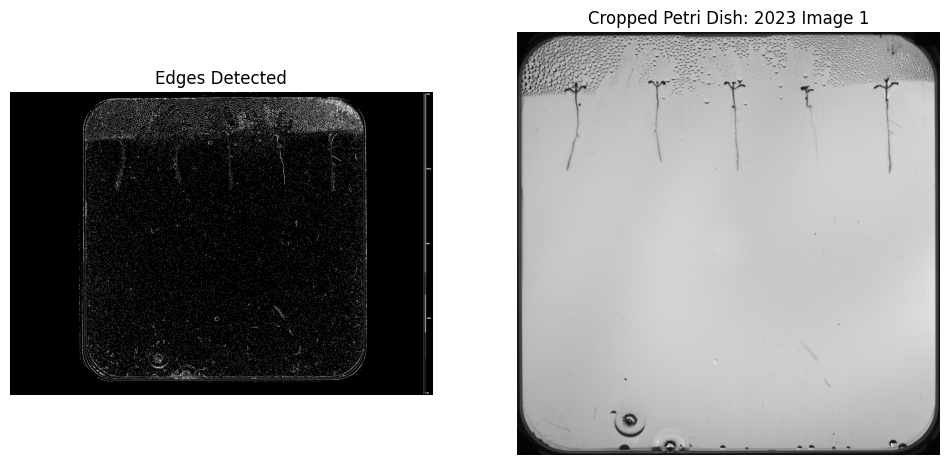

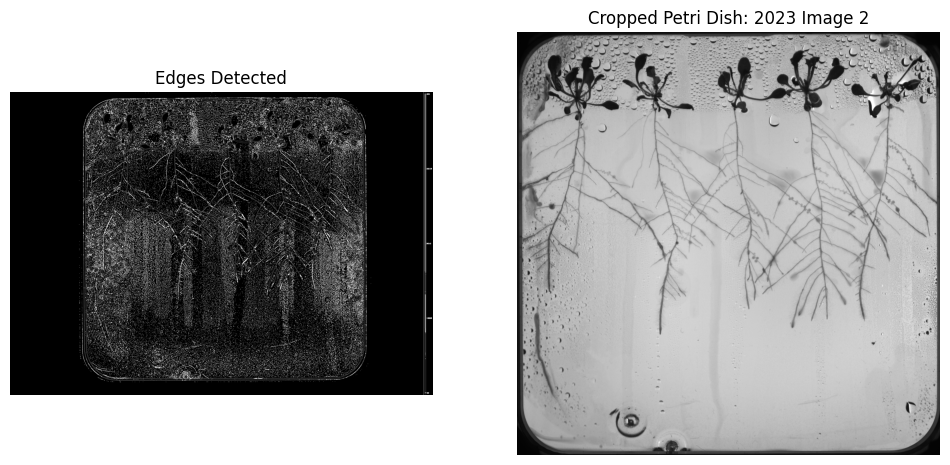

In [7]:
# Process and display each image
process_and_display(im1, "2024 Image 1")
process_and_display(im2, "2024 Image 2")
process_and_display(im3, "2023 Image 1")
process_and_display(im4, "2023 Image 2")